# Module 2 - Lab assignment - Few-shot Multi-document Question Answering with Mistral-7B.

This notebook presents an example of how to use Mistral-7B-Instruct model to perform few-shot multi-document question answering.

[Mistral](https://mistral.ai/news/announcing-mistral-7b/a) is a language model developed by Mistral AI, with 7.3 billion parameters. It outperforms larger models on various benchmarks involving both code and natural language. Mistral 7B uses a novel attention mechanisms to process long sequences. It is openly available under the Apache 2.0 license for unrestricted use.

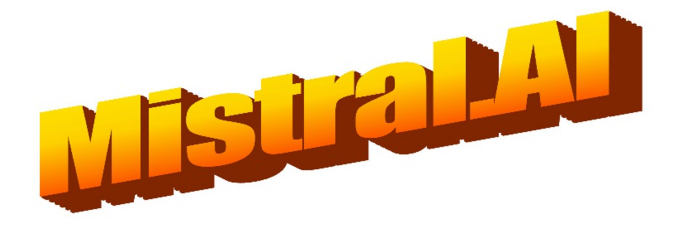

In this example, we evaluate Mistral-7B-Instruct available on the [Hugging Face model hub](https://huggingface.co/mistralai/Mistral-7B-Instruct-v0.1) on the [Incomplete Information Reading Comprehension (IIRC)](https://allenai.org/data/iirc) dataset. The IIRC dataset contains questions that require the model to reason over multiple documents to generate a complete answer. It is a challenging dataset that requires the model to extract relevant information from multiple sources and synthesize it to produce an accurate answer.

# Lab Assignment

For the lab assignment search for **`TODO:`** in the cells and write your code to accomplish the task.


# Installing required packages

In this example, we have to install the`transformers` from Hugging Face. [Hugging Face](https://huggingface.co/) is an AI startup that has gained significant traction in the NLP community recently. It provides a suite of open-source tools and libraries, making it easy for developers and researchers to work with state-of-the-art NLP models. Besides, we have to install the libs `bitsandbytes` and `accelerate`.

**`transformers`**:

Transformers is an open-source library for NLP developed by Hugging Face. It provides state-of-the-art pre-trained models for various NLP tasks, such as text classification, sentiment analysis, question-answering, named entity recognition, etc. The library is built on top of PyTorch and TensorFlow and provides easy-to-use interfaces to access pre-trained models and fine-tune them on specific tasks. The library also provides tools for training custom models and sharing them with the community.

**`bitsandbytes`**:

BitsAndBytes is an library designed to optimize the training of neural networks on modern GPUs. It offers efficient implementations of 8-bit optimizers, which significantly reduce the memory footprint of model parameters and gradients. This reduction in memory usage enables training larger models or using larger batch sizes within the same memory constraints. The library is particularly useful when working with large-scale models in NLP and deep learning, as it helps in mitigating the memory limitations often encountered. Additionally, BitsAndBytes is known for its compatibility with popular deep learning frameworks like PyTorch, making it a convenient addition to the existing training pipelines.

**`accelerate`**:

Accelerate is another library from Hugging Face, designed to simplify and accelerate training deep learning models. It provides an abstraction layer over complex distributed computing and mixed-precision training processes, allowing for easy scaling of models across multiple GPUs or TPUs. With Accelerate, developers and researchers can run their models on various hardware setups without extensive modifications to their code. This library effectively handles the intricacies of distributed training, making it more accessible to practitioners who may not have specialized knowledge in parallel computing. Accelerate integrates seamlessly with the Transformers library, further enhancing its utility in large-scale NLP model training and experimentation.

In [ ]:
!pip install transformers
!pip install -q -U bitsandbytes
!pip install -q -U accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.4/122.4 MB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 330.9/330.9 kB 24.8 MB/s eta 0:00:00


# Setting the device

In this example, we will use a GPU to speed up the processing of our model. GPUs (Graphics Processing Units) are specialized processors that are optimized for performing large-scale computations in parallel. By using a GPU, we can accelerate the training and inference of a machine learning model, which can significantly reduce the time required to complete these tasks.

Before we begin, we need to check whether a GPU is available and select it as the default device for our PyTorch operations. This is because PyTorch can use either a CPU or a GPU to perform computations, and by default, it will use the CPU.

For using a GPU in Google Colab:
1. Click on the "Runtime" menu at the top of the screen.
2. From the dropdown menu, click on "Change runtime type".
3. In the popup window that appears, select "GPU" as the hardware accelerator.
4. Click on the "Save" button.

That's it! Now you can use the GPU for faster computations in your notebook.

In [ ]:
!nvidia-smi

Sat Oct 19 02:41:03 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0              44W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [ ]:
import torch
device="cuda"

torch.set_default_device(device)

model_id = "mistralai/Mistral-Nemo-Instruct-2407"
# model_id = "mistralai/Mistral-7B-Instruct-v0.1"

# Downloading the model

This code below demonstrates how to load a pre-trained language model from the Hugging Face Transformers library with configuration for memory efficiency and optimization. Let's break down each part:

1. **Import Statements**:
    - `from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, pipeline`: Imports necessary classes from the `transformers` library. `AutoTokenizer` and `AutoModelForCausalLM` are used for tokenization and loading the causal language model, respectively. `BitsAndBytesConfig` is for advanced model quantization, and `pipeline` is a utility for easy inference.
    - `import transformers`: General import of the transformers library.
    - `import torch`: Imports the PyTorch library, which is the underlying framework for the transformers.

2. **Quantization Configuration (`bnb_config`)**:
    - `BitsAndBytesConfig`: A configuration class for model quantization.
        - `load_in_4bit=True`: Indicates that the model should be loaded with 4-bit quantization, reducing its memory footprint.
        - `bnb_4bit_quant_type="nf4"`: Specifies the quantization type. Here, `"nf4"` likely refers to a specific 4-bit quantization method.
        - `bnb_4bit_use_double_quant=True`: Enables double quantization, a technique for further compressing the model size while maintaining accuracy.

3. **Model Loading**:
    - `model_name = "mistralai/Mistral-7B-Instruct-v0.1"`: Specifies the model to be loaded. In this case, it's the Mistral-7B-Instruct model from Mistral AI.
    - `model = AutoModelForCausalLM.from_pretrained(...)`: This method loads the specified pre-trained model.
        - `model_name`: The variable containing the model's repository name.
        - `load_in_4bit=True`: Enables 4-bit quantization during model loading.
        - `quantization_config=bnb_config`: Applies the quantization configuration defined earlier.
        - `torch_dtype=torch.bfloat16`: Sets the data type of model parameters to bfloat16, which is a compact floating-point format offering a good balance between precision and memory usage.
        - `device_map="auto"`: Automatically maps the model to the appropriate processing unit (GPU or CPU) based on availability and hardware compatibility.
        - `trust_remote_code=True`: This setting allows the loading of custom code associated with the model from the Hugging Face hub. This is necessary for models that have custom layers or require specific initializations.


In [ ]:
!pip install huggingface_hub
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) N
Token is valid (permission: read).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [ ]:
## Requires A100

import torch
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM


model = AutoModelForCausalLM.from_pretrained(model_id,
                                             torch_dtype="auto")

model.to(device)

In [ ]:
# Quant models

from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, pipeline
import transformers
import torch

quantization_config = BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_compute_dtype=torch.bfloat16);

model = AutoModelForCausalLM.from_pretrained(model_id,
                                             device_map="auto",
                                             quantization_config=quantization_config,
                                             trust_remote_code=True)



config.json:   0%|          | 0.00/623 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/29.9k [00:00<?, ?B/s]

model-00001-of-00005.safetensors:   0%|          | 0.00/4.87G [00:00<?, ?B/s]

model-00002-of-00005.safetensors:   0%|          | 0.00/4.91G [00:00<?, ?B/s]

model-00003-of-00005.safetensors:   0%|          | 0.00/4.91G [00:00<?, ?B/s]

model-00004-of-00005.safetensors:   0%|          | 0.00/4.91G [00:00<?, ?B/s]

model-00005-of-00005.safetensors:   0%|          | 0.00/4.91G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

We also load the tokenizer for the model using the **`AutoTokenizer.from_pretrained`** method. The tokenizer is used to convert a piece of text into a sequence of tokens, which can then be fed into the model.

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_id,
                                          torch_dtype="auto")

tokenizer_config.json:   0%|          | 0.00/181k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.26M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

# Downloading the data

To use the Incomplete Information Reading Comprehension (IIRC) dataset as a benchmark, we need to download the data. The IIRC dataset consists of a set of documents and associated questions. We can download the dataset test set using the following code:



In [ ]:
!wget https://iirc-dataset.s3.us-west-2.amazonaws.com/iirc_test.json

--2024-10-19 02:48:07--  https://iirc-dataset.s3.us-west-2.amazonaws.com/iirc_test.json
Resolving iirc-dataset.s3.us-west-2.amazonaws.com (iirc-dataset.s3.us-west-2.amazonaws.com)... 52.92.228.58, 52.218.228.33, 3.5.87.105, ...
Connecting to iirc-dataset.s3.us-west-2.amazonaws.com (iirc-dataset.s3.us-west-2.amazonaws.com)|52.92.228.58|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2874825 (2.7M) [application/json]
Saving to: ‘iirc_test.json’

iirc_test.json      100%[===================>]   2.74M  2.20MB/s    in 1.2s    

2024-10-19 02:48:09 (2.20 MB/s) - ‘iirc_test.json’ saved [2874825/2874825]



Let's load the data and see what it looks like.

We are using the IIRC dataset, and we have imported the JSON library to read the test set file. We loaded the first example from the test set, which is a dictionary with keys 'questions', 'text', 'links', and 'title'.

The 'questions' key contains a list of dictionaries with keys 'question', 'context', 'answer', and 'question_links'. The 'text' key contains the text that may contain relevant information for answering the questions. The 'links' key is a list of dictionaries with keys 'target' and 'indices', indicating the hyperlink target and the position of the hyperlink in the text. The 'title' key contains the title of the document.

In this particular example, we can see that the question is "What is Zeus known for in Greek mythology?" and the answer is "being the sky and thunder god". The context contains three passages containing the text that may provide additional information.

In [ ]:
import json

test_set = json.load(open('iirc_test.json','r'))

test_set[0]

{'questions': [{'answer': {'type': 'span',
    'answer_spans': [{'text': 'sky and thunder god',
      'passage': 'zeus',
      'type': 'answer',
      'start': 83,
      'end': 102}]},
   'question': 'What is Zeus know for in Greek mythology?',
   'context': [{'text': 'he Palici the sons of Zeus',
     'passage': 'main',
     'indices': [684, 710]},
    {'text': 'in Greek mythology', 'passage': 'main', 'indices': [137, 155]},
    {'text': 'Zeus (British English , North American English ; , Zeús ) is the sky and thunder god in ancient Greek religion',
     'passage': 'Zeus',
     'indices': [0, 110]}],
   'question_links': ['Greek mythology', 'Zeus']}],
 'text': "The Palici (Παλικοί in Greek), or Palaci, were a pair of indigenous Sicilian chthonic deities in Roman mythology, and to a lesser extent in Greek mythology. They are mentioned in Ovid's Metamorphoses V, 406, and in Virgil's Aeneid IX, 585. Their cult centered on three small lakes that emitted sulphurous vapors in the Palagonia 

# Data Preparation

When working with the IIRC dataset, preparing the data before using it to evaluate models is necessary. Additionally, it is important to carefully choose how many questions to evaluate, as using GPT from OpenAI API can be costly. The data preparation process involves iterating through the test set,
extracting relevant information such as the question, documents containing relevant passages, and the true answer.

This is achieved by parsing the original JSON format and mapping it into a format that can be used to evaluate models.

In the code below, the preparation process is limited to a maximum of 50 questions due to the cost associated with using the OpenAI API. It involves iterating through each question and its corresponding context, creating a list of documents containing relevant information, and extracting the true answer based on its type. By preparing the data in this way, it can be more easily fed into GPT models, and compare the results.

We use a limited number of questions to reduce the costs of using OpenAPI API.

In [ ]:
max_questions = 50 # @param

test_set_questions = []
i = 0
while len(test_set_questions) < max_questions:

  item = test_set[i]
  for question in item['questions']:
    documents = []
    for doc in question['context']:
      documents.append({
          "title": doc['passage'] if doc['passage'] != "main" else item['title'],
          "content": doc['text']
      })
    true_answer = ""
    if question['answer']['type'] == "span":
      true_answer = ", ".join([a['text'] for a in question['answer']["answer_spans"]])
    elif question['answer']['type'] == "value":
        true_answer = "{0} {1}".format(question['answer']['answer_value'],question['answer']['answer_unit'])
    elif question['answer']['type'] == "binary":
        true_answer = question['answer']['answer_value']
    elif question['answer']['type'] == "none":
        true_answer = "Not enough information."
    test_set_questions.append({
        "question": question['question'],
        "documents": documents,
        "answer": true_answer
    })
    i+=1


The resulting prepared dataset is a dictionary with four keys. The "**`question`**" key contains the actual question to be answered, which in this case is "What is Zeus known for in Greek mythology?". The "**`documents`**" key is a list containing information that may be relevant to answering the question. Each document is a dictionary with a "title" key and a "content" key. The "title" key gives the name of the source of the information, while the "content" key provides the actual text of the source. In this case, there are three documents, all related to the topic of Greek mythology and Zeus. The "**`answer`**" key contains the correct answer to the question, which is "sky and thunder god".



In [ ]:
test_set_questions[0]

{'question': 'What is Zeus know for in Greek mythology?',
 'documents': [{'title': 'Palici', 'content': 'he Palici the sons of Zeus'},
  {'title': 'Palici', 'content': 'in Greek mythology'},
  {'title': 'Zeus',
   'content': 'Zeus (British English , North American English ; , Zeús ) is the sky and thunder god in ancient Greek religion'}],
 'answer': 'sky and thunder god'}

# Prompt Engineering with Mistral-7B-Instruct

Prompt engineering is a technique that involves providing the model with a prompt, which is a piece of text that instructs the model to perform a specific task. The model then generates the desired output based on the prompt. Prompting Mistral-7B-Instruct is quite different from prompting OpenAI's models. Mistral-7B-Instruct was finetuned on instruction datasets publicly available.

It's recommended to use the following chat template when using Mistral 7B Instruct:

```
<s>[INST] Instruction [/INST] Model answer</s>[INST] Follow-up instruction [/INST]
```

Note that `<s>` and `</s>` are special tokens for beginning of string (BOS) and end of string (EOS) while `[INST]` and `[/INST]` are regular strings that mark the beginning and end of the instruction. Consider the following example:

Prompt:

```
[INST] You are a helpful code assistant. Your task is to generate a valid JSON object based on the given information:

name: John
lastname: Smith
address: #1 Samuel St.

Just generate the JSON object without explanations:
[/INST]
```

Output:

```
{
  "name": "John",
  "lastname": "Smith",
  "address": "#1 Samuel St."
}
```

For few-shot prompt engineering, we can use the following template:

```
<s>[INST] You are a helpful code assistant. Your task is to generate a valid JSON object based on the given information. So for instance the following:

name: John
lastname: Smith
address: #1 Samuel St.

would be converted to:[/INST]
{
"address": "#1 Samuel St.",
"lastname": "Smith",
"name": "John"
}
</s>
[INST]
name: Ted
lastname: Pot
address: #1 Bisson St.
[/INST]
```

### **Important**:

* the **`</s>`** token after the first output, which is used to mark the end of the first output. It also serves as stop token for the model. The model will generate the second output until it generates the **`</s>`** token.

* the inputs are separated by the **`[INST]`** and **`[/INST]`** tokens. The model will generate the first output based on the first input, and the second output based on the second input.

See the [Prompt Engineering Guide](https://www.promptingguide.ai/models/mistral-7b) model card for more details.

In this example, we use the following instruction:

```
[INST]Answer the question based on the provided documents. Explain how the documents answer the question. If there is not enough information in the documents to answer the question, then state "not enough information".
```

Notice that we omit the `[\INST]` token, as it must be added after the the target documents and question.

In [ ]:
instruction = """<s>[INST]Answer the question based on the provided documents. Explain how the documents answer the question. If there is not enough information in the documents to answer the question, then state "not enough information". Always use single quote character: ' when quoting. Return the explanation and answer as valid json object.
"""

# Few-shot examples

The few-shot examples are crucial in this approach because they enable the model to learn how to perform the task with only a small number of examples. The few-shot examples allow the model to "understand" how to answer questions based on a small set of examples, which makes it more robust and capable of answering a wider range of questions.

In the code provided below, we define three multi-doc QA examples that we will use as few-shot examples.

In [ ]:
examples = [
    {
        "documents": [
            {"title": "Fred J. Shields", "content": "Ollie Murphy's first-half goal gave 'the Royals' a huge boost at half-time."},
            {"title": "Ollie Murphy", "content": "He plays club football for Carnaross"},
            {"title": "Ollie Murphy", "content": "He came to national prominence in 1999 when he was one of Meath's best player's"}
        ],
        "question": "Did Ollie Murphy play for any teams other than 'the Royals'?",
        "explanation": "Document 1 says that Ollie Murphy's first-half goal gave 'the Royals' a huge boost at half-time. However, this does not necessarily mean that Ollie only played for 'the Royals'. Document 2 states that Ollie plays club football for Carnaross. This suggests that Ollie may have played for other teams in addition to 'the Royals'. Document 3 says that Ollie came to national prominence in 1999 when he was one of Meath's best players. This also suggests that Ollie has played for other teams. Therefore, it is likely that Ollie has played for teams other than 'the Royals'.",
        "answer": "yes"
    },
    {
        "documents": [
            {"title": "Don Rendell", "content": "The club played in the Brunei Premier League in the early 2000s, winning the league title in 2002 and 2004."}
        ],
        "question": "What club came in second at the 2004 Brunei Premier League?",
        "explanation": "Despite the document 1 being about the premier league and saying who won it in 2004, there is not enough information to determine which club came in second place during that year.",
        "answer": "not enough information."
    },
    {
        "documents": [
            {"title": "Stacy Compton", "content": "Despicable Me, the first film in the series, and the first film from Illumination, was released on July 9, 2010."},
            {"title": "Miranda Cosgrove", "content": "Cosgrove's first television appearance (aside from commercials) was in 2001 as the voice of young Lana Lang in the pilot episode of Smallville."},
            {"title": "Miranda Cosgrove", "content": "In 2004, Cosgrove soon landed her first major role in a television series when she was awarded a main role in the Nickelodeon series Drake & Josh"},
            {"title": "Miranda Cosgrove", "content": "Also in 2004, Cosgrove guest-starred in a special episode of the animated series What's New, Scooby-Doo?, as well as guest-starring in a season five episode of Grounded For Life"},
            {"title": "Miranda Cosgrove", "content": "The television series, which aired on Disney, is a spin-off of the original film, Lilo & Stitch"},
            {"title": "Miranda Cosgrove", "content": "The first of these appearances was in Zoey 101. Cosgrove later guest starred on an episode of Unfabulous,"},
            {"title": "Miranda Cosgrove", "content": "However, Cosgrove was already in the works of starring in her own sitcom, titled iCarly, released on September 8, 2007."}
        ],
        "question": "How many TV shows had Miranda Cosgrove been featured in by the year Despicable Me was released?",
        "explanation": "According to document 1, Despicable Me was released on July 9, 2010.Document 2 states that Cosgrove's first television appearance was in 2001 as the voice of young Lana Lang in the pilot episode of Smallville.Document 3 says that, in 2004, Cosgrove landed her first major role in a television series when she was awarded a main role in the Nickelodeon series Drake & Josh.Document 4 states that, also in 2004, Cosgrove guest-starred in a special episode of the animated series What's New, Scooby-Doo?, as well as guest-starring in a season five episode of Grounded For Life.Document 5 says that the television series, which aired on Disney, is a spin-off of the original film, Lilo & Stitch.Document 6 states that the first of these appearances was in Zoey 101. Cosgrove later guest starred on an episode of Unfabulous.Document 7 says that, however, Cosgrove was already in the works of starring in her own sitcom, titled iCarly, released on September 8, 2007.Therefore, Miranda Cosgrove had been featured in 8 TV shows by the year Despicable Me was released.",
        "answer": "8 TV shows"
    }
]

# Inference

The code below defines a function named `generate` that is used to generate text output from Mistral-7B. The function takes a string input, `text`, and processes it using a pre-trained model and tokenizer. Here's a breakdown of its key components:

1. **Function Definition**:
   - `def generate(text)`: Defines the function `generate` with a single parameter, `text`, which is the input text for generation.

2. **Tokenization**:
   - The input text is tokenized using a tokenizer. `return_tensors="pt"` indicates that the output will be PyTorch tensors. `add_special_tokens=False` suggests that special tokens for sequence start or end are not automatically added to the input.

3. **Model Inputs**:
   - The tokenized input is moved to a specified device (like GPU or CPU), making it ready for the model to process.

4. **Generating Output**:
   - The `with torch.no_grad():` block ensures that no gradients are calculated during the forward pass, reducing memory usage and speeding up computation.
   -  Then,  the function generates the output using the model.

5. **Decoding and Returning the Output**:
   - The function decodes the generated token IDs back into a string. It skips the part of the output that corresponds to the input tokens and also skips any special tokens in the decoding process. This ensures that the returned text is clean and readable, containing only the generated content without any formatting tokens.


In [ ]:
def generate(text):
  encodeds = tokenizer(text, return_tensors="pt", add_special_tokens=False)

  # 2. move the encoded input to the device
  model_inputs = encodeds.to(device)

  #
  # 2. generate the output
  outputs = model.generate(**model_inputs, pad_token_id=tokenizer.eos_token_id, max_new_tokens=1000)

  # 3. decode and return the outputs
  decoded = tokenizer.decode(outputs[0], skip_special_tokens=True)

  return decoded


In [ ]:
import pdb

def generate_from_chat(chat):
  tokenized_chat = tokenizer.apply_chat_template(chat, tokenize=True, add_generation_prompt=True, return_tensors="pt")
  outputs = model.generate(tokenized_chat, pad_token_id=tokenizer.eos_token_id, max_new_tokens=1000)
  decoded = tokenizer.decode(outputs[0])

  return decoded


# Using Chat template to generate

In [53]:
import json
from json.decoder import JSONDecodeError

chat_instruction = """Answer the question based on the provided documents. Explain how the documents answer the question. If there is not enough information in the documents to answer the question, then state 'not enough information'. Always use single quote character: ' when quoting. Return the explanation and answer in traditional chinese as valid json object only, do not generate anything else.
"""

chat_user_template = """
{documents}

{question}
"""

chat_assistant_template = """
{{
"explanation": "{explanation}",
"answer": "{answer}"
}}
"""

def chat_qa(question, input_documents, examples):
  # Loop through the examples and format them
  chat = []
  chat.append({ "role": "system", "content": chat_instruction })
  for example in examples:
    # Combine documents for each example
    documents = ""
    for j, doc in enumerate(example["documents"]):
      documents += f"[Document {j+1}]: Title: {doc['title']}. Content: {doc['content']}\n"

    # Add formatted example to the prompt
    user = chat_user_template.format(documents=documents, question=example['question'])
    chat.append({ "role": "user", "content": user })
    assist = chat_assistant_template.format(explanation=example['explanation'], answer=example['answer'])
    chat.append({ "role": "assistant", "content": assist })

  # Setup our question
  documents = ""
  for j, doc in enumerate(input_documents):
    documents += f"[Document {j+1}]: Title: {doc['title']}. Content: {doc['content']}\n"
  user = chat_user_template.format(documents=documents, question=question)
  chat.append({ "role": "user", "content": user })

  res = generate_from_chat(chat)
  json_str = res.split("[/INST]")[-1].strip()
  json_str = json_str.replace("</s>", "")

  # pdb.set_trace()

  try:
    json_object = json.loads(json_str)
  except JSONDecodeError as e:
    print(f"Error decoding JSON: {e}")
    pdb.set_trace()
    print(res)
    print(json_str)
    return None

  return json_object


# Multi-document question answering

Now we define the input and output templates to structure the interaction with the model for multi-document question answering. The `input_template` is used to format each example (both few-shot examples and the target example) in a consistent way, including the documents and the question. The `output_template` is designed to structure the model's responses, encapsulating the generated explanation and answer in a JSON-like format. This structured approach facilitates clearer communication with the model, aiding in more accurate and relevant responses for the task.

In [ ]:
import pdb
import json
from json.decoder import JSONDecodeError

test_template = """
<s>[INST]Answer the question based on the provided documents. Explain how the documents answer the question. If there is not enough information in the documents to answer the question, then state "not enough information". Return the explanation and answer in a valid json object.
[Document 1]: Title: Fred J. Shields. Content: Ollie Murphy's first-half goal gave 'the Royals' a huge boost at half-time.
[Document 2]: Title: Ollie Murphy. Content: He plays club football for Carnaross
[Document 3]: Title: Ollie Murphy. Content: He came to national prominence in 1999 when he was one of Meath's best player's

Question: Did Ollie Murphy play for any teams other than 'the Royals'?

would be converted to:
 [/INST]
{
"explanation": "Document 1 says that Ollie Murphy's first-half goal gave 'the Royals' a huge boost at half-time. However, this does not necessarily mean that Ollie only played for 'the Royals'. Document 2 states that Ollie plays club football for Carnaross. This suggests that Ollie may have played for other teams in addition to 'the Royals'. Document 3 says that Ollie came to national prominence in 1999 when he was one of Meath's best players. This also suggests that Ollie has played for other teams. Therefore, it is likely that Ollie has played for teams other than 'the Royals'.",
"answer": "yes"
}
</s> [INST]
[Document 1]: Title: Don Rendell. Content: The club played in the Brunei Premier League in the early 2000s, winning the league title in 2002 and 2004.

Question: What club came in second at the 2004 Brunei Premier League?

would be converted to:
 [/INST]
{
"explanation": "Despite the document 1 being about the premier league and saying who won it in 2004, there is not enough information to determine which club came in second place during that year.",
"answer": "Not enough information"
}
</s> [INST]
[Document 1]: Title: Stacy Compton. Content: Despicable Me, the first film in the series, and the first film from Illumination, was released on July 9, 2010.
[Document 2]: Title: Miranda Cosgrove. Content: Cosgrove's first television appearance (aside from commercials) was in 2001 as the voice of young Lana Lang in the pilot episode of Smallville.
[Document 3]: Title: Miranda Cosgrove. Content: In 2004, Cosgrove soon landed her first major role in a television series when she was awarded a main role in the Nickelodeon series Drake & Josh
[Document 4]: Title: Miranda Cosgrove. Content: Also in 2004, Cosgrove guest-starred in a special episode of the animated series What's New, Scooby-Doo?, as well as guest-starring in a season five episode of Grounded For Life
[Document 5]: Title: Miranda Cosgrove. Content: The television series, which aired on Disney, is a spin-off of the original film, Lilo & Stitch
[Document 6]: Title: Miranda Cosgrove. Content: The first of these appearances was in Zoey 101. Cosgrove later guest starred on an episode of Unfabulous,
[Document 7]: Title: Miranda Cosgrove. Content: However, Cosgrove was already in the works of starring in her own sitcom, titled iCarly, released on September 8, 2007.

Question: How many TV shows had Miranda Cosgrove been featured in by the year Despicable Me was released?

would be converted to:
 [/INST]
{
"explanation": "According to document 1, Despicable Me was released on July 9, 2010.Document 2 states that Cosgrove's first television appearance was in 2001 as the voice of young Lana Lang in the pilot episode of Smallville.Document 3 says that, in 2004, Cosgrove landed her first major role in a television series when she was awarded a main role in the Nickelodeon series Drake & Josh.Document 4 states that, also in 2004, Cosgrove guest-starred in a special episode of the animated series What's New, Scooby-Doo?, as well as guest-starring in a season five episode of Grounded For Life.Document 5 says that the television series, which aired on Disney, is a spin-off of the original film, Lilo & Stitch.Document 6 states that the first of these appearances was in Zoey 101. Cosgrove later guest starred on an episode of Unfabulous.Document 7 says that, however, Cosgrove was already in the works of starring in her own sitcom, titled iCarly, released on September 8, 2007.Therefore, Miranda Cosgrove had been featured in 8 TV shows by the year Despicable Me was released.",
"answer": "8 TV shows"
}
</s> [INST]
[Document 1]: Title: Pele. Content: Edson Arantes do Nascimento (Brazilian Portuguese: [ˈɛdsõ aˈɾɐ̃tʃiz du nasiˈmẽtu]; 23 October 1940 – 29 December 2022), better known by his nickname Pelé (Portuguese pronunciation: [peˈlɛ]), was a Brazilian professional footballer who played as a forward. Widely regarded as one of the greatest players of all time, he was among the most successful and popular sports figures of the 20th century.[2][3] In 1999, he was named Athlete of the Century by the International Olympic Committee and was included in the Time list of the 100 most important people of the 20th century. In 2000, Pelé was voted World Player of the Century by the International Federation of Football History & Statistics (IFFHS) and was one of the two joint winners of the FIFA Player of the Century. His 1,279 goals in 1,363 games, which includes friendlies, is recognised as a Guinness World Record.[4]
[Document 2]: Title Steve Jobs. Content: Steven Paul Jobs (February 24, 1955 – October 5, 2011) was an American business magnate, inventor, and investor. He was the co-founder, chairman, and CEO of Apple; the chairman and majority shareholder of Pixar; a member of The Walt Disney Company's board of directors following its acquisition of Pixar; and the founder, chairman, and CEO of NeXT. He was a pioneer of the personal computer revolution of the 1970s and 1980s, along with his early business partner and fellow Apple co-founder Steve Wozniak.

Question = "How old were Pelé when Steve Jobs died?"

would be converted to:
 [/INST]
"""


input_template = """
{documents}

{question}

would be converted to:
 [/INST]
"""
output_template = """
{{
"explanation": "{explanation}",
"answer": "{answer}"
}}
</s> [INST]
"""

def qa(question, input_documents, examples):
  # Write the instruction
  prompt = instruction+"\n\n"
  # Add the few-shot examples
  i = 1

  # Loop through the examples and format them
  for example in examples:
    # Combine documents for each example
    documents = ""
    for j, doc in enumerate(example["documents"]):
      documents += f"[Document {j+1}]: Title: {doc['title']}. Content: {doc['content']}\n"

    # Add formatted example to the prompt
    prompt += input_template.format(i=i,
                                      documents=documents,
                                      question=example['question'])

    prompt += output_template.format(explanation=example['explanation'],
                                      answer=example['answer'])
    i += 1

  # Add target example
  documents = ""
  for k, doc in enumerate(input_documents):
    documents += f"[Document {k+1}]: Title: {doc['title']}. Content: {doc['content']}\n"

  prompt += input_template.format(i=i,
                                      documents=documents.replace('"',"'"),
                                      question=question.replace('"',"'"))
  # print(prompt)

  res = generate(prompt)
  json_str = res.split("[/INST]")[-1].strip()

  # pdb.set_trace()

  try:
    json_object = json.loads(json_str)
  except JSONDecodeError as e:
    print(f"Error decoding JSON: {e}")
    pdb.set_trace()
    print(res)
    print(json_str)
    return None

  return json_object




# Running

The code provided below is the main code to run the experiments. It uses the test questions set and loops through each question, retrieving the ground truth documents, the query question, and the pre-defined examples.

In [ ]:
from tqdm import tqdm

k_shot = "3" # @param [1,2,3]
for question in tqdm(test_set_questions):
    # del question['predicted_answer']
    if "predicted_answer" not in question:
      res = chat_qa(question['question'], question['documents'], examples[:int(k_shot)])

      question["explanation"] = res["explanation"]
      question["predicted_answer"] = res["answer"]

100%|██████████| 52/52 [06:01<00:00,  6.94s/it]


# Evaluation

In this section, we evaluate the performance of our model by calculating the exact match score and the F1 score using bag of words. To accomplish this, we have defined some helper functions.

The **`normalize_text`** function takes a text and normalizes it by converting it to lowercase and removing any non-alphanumeric characters. The **`get_tokens`** function tokenizes the text after normalization.

The **`exact_match`** function takes the predicted answer and the true answer and returns whether they match exactly after normalization. The **`f1_bag_of_words`** function takes the predicted answer and the true answer, tokenizes them, and calculates their F1 score using the bag of words approach.

The bag of words approach is a technique used to measure the similarity between two sets of texts by counting the frequency of each word in both sets and then calculating their overlap.

In [ ]:
import re
from collections import Counter

def normalize_text(text):
    """
    Helper function to normalize the text
    """
    text = text.lower()
    text = re.sub(r"[^a-zA-Z0-9]+", " ", text)
    return text.strip()

def get_tokens(text):
    """
    Helper function to tokenize text
    """
    text = normalize_text(text)
    return text.split()

def exact_match(pred_answer, true_answer):
    """
    Calculates the exact match score
    """
    return normalize_text(pred_answer) == normalize_text(true_answer)

def f1_bag_of_words(pred_answer, true_answer):
    """
    Calculates the F1 score using bag of words
    """
    pred_tokens = get_tokens(pred_answer)
    true_tokens = get_tokens(true_answer)

    pred_counter = Counter(pred_tokens)
    true_counter = Counter(true_tokens)

    common = pred_counter & true_counter
    num_same = sum(common.values())

    if num_same == 0:
        return 0

    precision = 1.0 * num_same / len(pred_tokens)
    recall = 1.0 * num_same / len(true_tokens)
    f1 = (2 * precision * recall) / (precision + recall)

    return f1


In the below code, we are evaluating the performance of the model for multi-document question answering by calculating the: Exact Match (EM) and F1 score using bag of words.

The code iterates over each item in the validation dataset and calculates the F1 and EM scores using the **`f1_bag_of_words`** and **`exact_match`** functions defined earlier. The maximum score of F1 and EM is then taken for each item and appended to their respective lists, **`f1s`** and **`ems`**.

The mean of the **`f1s`** and **`ems`** lists are then calculated using NumPy's **`np.mean`** function and assigned to **`mean_f1`** and **`mean_em`** variables, respectively. Finally, the average EM and F1 scores are printed using formatted string literals.

In [ ]:
import numpy as np

f1s, ems = [], []
for question in test_set_questions:
  if "predicted_answer" in question:
    f1 = f1_bag_of_words(question["predicted_answer"],question["answer"])
    em = exact_match(question["predicted_answer"],question["answer"])
    print(f"Question: {question['question']}")
    print(f"Predicted: {question['predicted_answer']}")
    print(f"Explanation: {question['explanation']}")
    print(f"True answer: {question['answer']}")
    print(f1)
    print(em)
    print()
    f1s.append(f1)
    ems.append(em)

mean_em = np.mean(ems)
mean_f1 = np.mean(f1s)
print(f"Exact match: {mean_em:.3f}\nF1-bow: {mean_f1:.3f}")

Question: What is Zeus know for in Greek mythology?
Predicted: 'Zeus is known for being the sky and thunder god in Greek mythology'
Explanation: Document 3 states that Zeus is the sky and thunder god in ancient Greek religion. This information is sufficient to answer the question.
True answer: sky and thunder god
0.47058823529411764
False

Question: How long had the First World War been over when Messe was named aide-de-camp?
Predicted: not enough information
Explanation: Document 1 states that Giovanni Messe became aide-de-camp to King Victor Emmanuel III in an unspecified year. Document 2 provides the dates for World War I, which ended on 11 November 1918. Without the specific year Messe was named aide-de-camp, we cannot determine how long the First World War had been over.
True answer: 5 years
0
False

Question: How old was Messe when the First World War started?
Predicted: 31 years old
Explanation: Document 1 states that Giovanni Messe was born on December 10, 1883. Document 2 says

# Try your own questions

You can try multi-document QA using your own examples. Google for topics of your interest and provide the documents and the question as in the example below.

The documents used as an example below are the first paragraph from the pages "Pele" and "Steve Jobs" from Wikipedia. It is just a toy example. You can try more realistic ones.

In [ ]:
documents = [
    {
        "title": "Pele",
        "content": "Edson Arantes do Nascimento (Brazilian Portuguese: [ˈɛdsõ aˈɾɐ̃tʃiz du nasiˈmẽtu]; 23 October 1940 – 29 December 2022), better known by his nickname Pelé (Portuguese pronunciation: [peˈlɛ]), was a Brazilian professional footballer who played as a forward. Widely regarded as one of the greatest players of all time, he was among the most successful and popular sports figures of the 20th century.[2][3] In 1999, he was named Athlete of the Century by the International Olympic Committee and was included in the Time list of the 100 most important people of the 20th century. In 2000, Pelé was voted World Player of the Century by the International Federation of Football History & Statistics (IFFHS) and was one of the two joint winners of the FIFA Player of the Century. His 1,279 goals in 1,363 games, which includes friendlies, is recognised as a Guinness World Record.[4]"
    },
    {
        "title": "Steve Jobs",
        "content": "Steven Paul Jobs (February 24, 1955 – October 5, 2011) was an American business magnate, inventor, and investor. He was the co-founder, chairman, and CEO of Apple; the chairman and majority shareholder of Pixar; a member of The Walt Disney Company's board of directors following its acquisition of Pixar; and the founder, chairman, and CEO of NeXT. He was a pioneer of the personal computer revolution of the 1970s and 1980s, along with his early business partner and fellow Apple co-founder Steve Wozniak."
    }
]

question = "How old were Pelé when Steve Jobs died?"
response = chat_qa(question, documents, examples[:3])

print(f"Explanation: {response['explanation']}\nAnswer: {response['answer']}")

In [54]:
documents = [
    {
        "title": "歸綽嶢",
        "content": "香港女歌手、演員及模特兒。原名歸南茜，2021年底改至現名。於2022年10月加盟香港華納唱片，並於2023年1月31日以《Teaser》正式出道，出道首年獲頒《叱咤樂壇流行榜頒獎典禮2023》「叱咤樂壇生力軍女歌手銀獎」、《Chill Club 推介榜年度推介23/24》「Chill Club年度新人女歌手」及《第四十五屆十大中文金曲》「最有前途新人獎優異獎」三台新人獎。"
    },
    {
        "title": "簡歷",
        "content": "歸綽嶢於2006年至2012年間就讀保良局陸慶濤小學。期間因為該小學於2010年與保良局羅氏基金中學結為一條龍學校，她於是能夠以直接升讀方式入讀保良局羅氏基金中學。2017年曾參與香港學校戲劇節獲傑出演員獎。大學入讀嶺南大學文化研究學系，2019-2020學年獲香港特區政府獎學金。"
    }
]

question = "歸南茜讀什麼中學？"
response = chat_qa(question, documents, examples[:3])

print(f"Explanation: {response['explanation']}\nAnswer: {response['answer']}")


Explanation: 文件1提到歸南茜於2022年10月加盟香港華納唱片，並且在2023年1月31日以《Teaser》正式出道。文件2提到歸南茜於2006年至2012年間就讀保良局陸慶濤小學，並且於2010年與保良局羅氏基金中學結為一條龍學校，她於是能夠以直接升讀方式入讀保良局羅氏基金中學。因此，歸南茜讀的是保良局羅氏基金中學。
Answer: 保良局羅氏基金中學
